# Squeeze dispersion in the Samoan Passage

## Introduction

In this notebook we calculate diffusivity, $\kappa$, from profiles of turbulent dissipation, $\epsilon$ and 
potential density referenced to 4,000 meters depth --- $\sigma_4$ --- observed in the Samoan Passage
by Alford, Carter, Girton and Voet. We define the density variable ρ via:

$$ \rho = \sigma_4 + 1000 $$.

Our procedure is:

1. Sort $\sigma_4$ in $z$ to obtain a stable density profile. We permute $\epsilon$ by the same vector that sorts $\sigma$, so that the relationship between turbulent dissipation and $\sigma$ remains the same, while it is the association between $\sigma$ and height $z$ that changes.
2. Performing a moving average of both $\sigma$ and $\epsilon$ over some depth $d$.
3. Discretize density space into a small number of layers, and use trapezoidal integration to calculate the layer-integrated turbulent dissipation.
4. Use

$$ N^2 \equiv -\frac{g \Delta \rho}{\rho_0 \Delta \zeta} $$

to calculate 

$$\kappa_\mathrm{local} = \frac{\Gamma \epsilon}{N^2} = \Gamma \epsilon \left ( -\frac{\rho_0 \Delta \zeta}{g \Delta \rho} \right )$$, 

where $\Delta \rho$ is the width of the layer in density space, and $\Delta \zeta$ is the vertical separation betwen the edges of the layer.
5. Define an integral over the Samoan passage transect, using the distance along the transect as the spatial coordinate.
6. Calculate the average buoyancy flux $\langle \Gamma \epsilon \rangle$ and the thickness weighted buoyancy gradient 

$$ \left \langle \frac{1}{N^2} \right \rangle = - \frac{\rho_0 \langle \Delta \zeta \rangle}{\Delta \rho g} $$.

7. Calculate the effective diffusivity across the layer with 

$$ \kappa_\mathrm{effective} = \langle \Gamma \epsilon \rangle \left \langle \frac{1}{N^2} \right \rangle 
= - \frac{\rho_0}{\Delta \rho g} \langle \Gamma \epsilon \rangle \langle \Delta \zeta \rangle $$.

## Initialization

Below, we initialize the pacakages we need.


In [1]:
using Pkg
Pkg.activate("..")

using Printf, Statistics,
        JLD2, FileIO, Interpolations, PyCall, PyPlot, PyPlotPlus, DataStructures,
        SqueezeDispersion.Samoan

@pyimport matplotlib.colors as clrs

using LinearAlgebra: norm

usecmbright() # for plotting

In [2]:
function compileoverturns(vmp; davg=nothing)

    overturns = Dict{Symbol,Array{Float64,1}}()
       overturns[:z] = Array{Float64,1}()
     overturns[:sig] = Array{Float64,1}()
      overturns[:dz] = Array{Float64,1}()
    overturns[:dsig] = Array{Float64,1}()

    for name in keys(vmp)
        z, ep, sig = unpack_vmp_profile(vmp[name])
        
        if davg != nothing
            sig = movingavg(sig, davg)
        end
        
        z_ov, sig_ov, z_delta, sig_delta = getoverturns(z, sig)
        
        append!(overturns[:z], z_ov)
        append!(overturns[:sig], sig_ov)    
        append!(overturns[:dz], z_delta) 
        append!(overturns[:dsig], sig_delta)
    end
    
    overturns
end

function onlygoods(A...)
    a1 = A[1]
    iigood = .!isnan.(a1)
    iigood .*= isfinite.(a1)
    (a[iigood] for a in A)
end

toradians(x...) = (π/180 * y for y in x)

function trapz(x, f)
    kernel = @views @. (f[2:end] + f[1:end-1]) * (x[2:end] - x[1:end-1])
    return 0.5*sum(kernel)
end

function enmesh(yedges, x, fx; uniform=false, rev=false)    
    # Start up
    y = @views @. 0.5*(yedges[2:end] + yedges[1:end-1])
    
    if !uniform
        fx_itp = interpolate((x,), fx, Gridded(Linear()))
    else
        fx_itp0 = interpolate(fx, BSpline(Linear()))
        fx_itp = scale(fx_itp0, x)
    end
    
    fx_itp = extrapolate(fx_itp, 0)
    fy = similar(y)
    
    for i = 1:length(y)
        # Find data within cell
        left = yedges[i]
        right = yedges[i+1]
        ii = left .<= x .<= right
        
        # Construct array of data within cell, using linear 
        # interpolation to find endpoints
        xcell = cat([left], x[ii], [right], dims=1)
        fcell = cat([fx_itp(left)], fx[ii], [fx_itp(right)], dims=1)
        
        # Compute cell-average of data.
        fy[i] = trapz(xcell, fcell) / (right - left)
    end
    
    y, fy
end
    
function layerthickness(sig, z, sig_edges)
    z_itp = interpolate((sig,), z, Gridded(Linear()))
    z_itp = extrapolate(z_itp, Flat())
    z_edges = z_itp(sig_edges)
    z_edges[1:end-1] .- z_edges[2:end] # defines thickness>0 for stable profiles
end
    
function layerwise(sig_raw, ep_raw, z, sig_edges; davg::Int=0)      
    sig_sorted, ep_sorted = simulsort(sig_raw, ep_raw, rev=true)
    sig_good, ep_good, z_good = onlygoods(sig_sorted, ep_sorted, z)
        
    if davg > 0
        sig_good = movingavg(sig_good, davg=davg)
        ep_good = movingavg(ep_good, davg=davg)
    end
    
    # Flip 
    sig_good = reverse(sig_good)
    ep_good = reverse(ep_good)
    z_good = reverse(z_good)
    
    sig, ep = enmesh(sig_edges, sig_good, ep_good)
    sig = reverse(sig)
    ep = reverse(ep)
    
    dζ = layerthickness(sig_good, z_good, sig_edges)
    
    z_itp = interpolate((sig_good,), z_good, Gridded(Linear()))
    z_itp = extrapolate(z_itp, NaN)
    ζ = z_itp(sig)
    ζ_edges = z_itp(sig_edges)
    
    sig, ep, dζ, ζ, ζ_edges
end
    
function layerwise(sig_raw, z, sig_edges; davg::Int=0)      
    sig_sorted = sort(sig_raw, rev=true)
    sig_good, z_good = onlygoods(sig_sorted, z)
        
    if davg > 0
        sig_good = movingavg(sig_good, davg=davg)
    end
    
    # Flip 
    sig_good = reverse(sig_good)
    z_good = reverse(z_good)
    
    sig = @views @. 0.5*(sigedges[2:end] + sigedges[1:end-1])
    sig = reverse(sig)
    
    dζ = layerthickness(sig_good, z_good, sig_edges)
    
    z_itp = interpolate((sig_good,), z_good, Gridded(Linear()))
    z_itp = extrapolate(z_itp, NaN)
    ζ = z_itp(sig)
    ζ_edges = z_itp(sig_edges)
    
    sig, dζ, ζ, ζ_edges
end
    
function layer_vmp_data(vmp, sig_edges)
    nsig = length(sig_edges) - 1
    
    sig = zeros(nsig, nvmp)
    ep = zeros(nsig, nvmp)
    dζ = zeros(nsig, nvmp)
    ζ = zeros(nsig, nvmp)
    ζ_edges = zeros(nsig+1, nvmp)

    for (i, profile) in enumerate(values(vmp))
        z, ep_raw, sig_raw = unpack_vmp_profile(profile)  
        sig[:, i], ep[:, i], dζ[:, i], ζ[:, i], ζ_edges[:, i] = layerwise(sig_raw, ep_raw, z, sig_edges)
    end
    
    sig, ep, dζ, ζ, ζ_edges
end
    
    
function layerwise_ctd_data(sig_raw, z, sig_edges; davg::Int=0)
end
    

function passage_coordinate(vmp)
    d = zeros(length(vmp))
    for (i, profile) in enumerate(values(vmp))
        d[i] = profile["distance"]
    end
    return d
end

function passage_average(u, vmp)
    d = passage_coordinate(vmp)
    nsigma, nvmp = size(u)
    uavg = zeros(nsigma)
    for i = 1:nsigma
        usigma = view(u, i, :)
        uavg[i] = trapz(d, usigma)
    end
    return uavg / (d[end] - d[1])
end
    
const Γ = 0.2 # mixing coefficient
const g = 9.81 # gravitational constant
const ρ0 = 1045.85 # reference density

Nsq(Δρ, Δζ) = -g*Δρ/(ρ0*Δζ)
localdiffusivity(ε, Δρ, Δζ) = Γ*ε/Nsq(Δρ, Δζ)
effectivediffusivity(ε_avg, Δρ, Δζ_avg) = -Γ*ε_avg * ρ0*Δζ_avg/(g*Δρ)

effectivediffusivity (generic function with 1 method)

## Load and manipulate data

Below we load the CTD and VMP data. To facilitate the creation of an 'along-track' axis, we order the VMP data by latitude. Because the Samoan passage is nearly oriented north-south, we then calculate along-track distance as the cumulative distance between each station.

In [3]:
datapath = joinpath("..", "data", "samoanpassagedata.jld2")
ctd = load(datapath, "ctd")
vmp = load(datapath, "vmp")

# Sort vmp data from south to north
vmpbylat = OrderedDict{Float64,Any}()
for (name, profile) in vmp
    profile["name"] = name
    vmpbylat[profile["lat"]] = profile
end

sort!(vmpbylat)
vmp = OrderedDict{String,Any}()
for profile in values(vmpbylat)
    vmp[profile["name"]] = profile
end

# Make dictionary of density data
densitydata = OrderedDict{Float64,Any}()
for (name, profile) in vmp
    @show name
    densityprofile = Dict{String,Any}()
    
    z, ep, sig = unpack_vmp_profile(profile)
    densityprofile["lat"] = profile["lat"]
    densityprofile["lon"] = profile["lon"]
    densityprofile["sig"] = sig
    densityprofile["z"] = z

    densitydata[profile["lat"]] = densityprofile
end

for (i, lat) in enumerate(ctd["lat"])
    densityprofile = Dict{String,Any}()
    
    densityprofile["lat"] = lat
    densityprofile["lon"] = ctd["lon"][i]
    densityprofile["sig"] = ctd["sigma4"][:, i]
    densityprofile["z"] = -reverse(ctd["depth"])
    
    densitydata[lat] = densityprofile
end

sort!(densitydata)

nz, nctd = size(ctd["sigma4"])
nvmp = length(vmp)
println("CTD data size: ndepth = $nz, nctd = $nctd, nvmp = $nvmp\n")

firstprofile = "SP1_Line9_02"
lat0 = vmp[firstprofile]["lat"]
lon0 = vmp[firstprofile]["lon"]
dist0 = 0.0

println("VMP profiles:\n")
for (i, profile) in enumerate(values(vmp))
    z, ep, sig = unpack_vmp_profile(profile)
    
    lat = profile["lat"]
    lon = profile["lon"]
    
    # Calculate along-track coordinate
    lat1, lon1, lat2, lon2 = toradians(lat0, lon0, lat, lon)
    profile["distance"] = latlondist(lat1, lon1, lat2, lon2) + dist0
    
    @printf("% 13s (%.2f N, %.2f W) | x: % 7.2f km, z: (%d, %d) meters, σ₄: (%.5f, %.5f) kg/m³\n", 
        profile["name"], lat, lon, profile["distance"]*1e-3, z[1], z[end], 
        nanmaximum(sig), nanminimum(sig))
    
    dist0 = profile["distance"]
    lat0 = lat
    lon0 = lon  
end

first = true
dist0 = 0.0
println("\n\nDensity profiles:\n")
for (i, profile) in enumerate(values(densitydata))
    
    if first
        lat0 = profile["lat"]
        lon0 = profile["lon"] 
        first = false
    end
    
    lat = profile["lat"]
    lon = profile["lon"]
    
    # Calculate along-track coordinate
    lat1, lon1, lat2, lon2 = toradians(lat0, lon0, lat, lon)
    profile["distance"] = latlondist(lat1, lon1, lat2, lon2) + dist0
    
    @printf("(%.2f N, %.2f W) | x: % 7.2f km, z: (% 5d, % 5d) meters, σ₄: (%.5f, %.5f) kg/m³\n", 
        lat, lon, profile["distance"]*1e-3, profile["z"][1], profile["z"][end], 
        nanmaximum(profile["sig"]), nanminimum(profile["sig"]))
    
    dist0 = profile["distance"]
    lat0 = lat
    lon0 = lon  
end

name = "SP1_Line9_02"
name = "SP1_Line9_04"
name = "SP1_Line9_06"
name = "SP1_Line9_07"
name = "SP1_Line9_08"
name = "SP1_Line9_09"
name = "SP1_Line9_102"
name = "SP1_Line9_112"
name = "SP1_Line9_13"
name = "SP1_Line9_14"
name = "SP1_Line9_15"
name = "SP1_Line9_16"
name = "SP1_Line9_17"
CTD data size: ndepth = 6001, nctd = 18, nvmp = 13

VMP profiles:

 SP1_Line9_02 (-9.83 N, -169.31 W) | x:    0.00 km, z: (-5303, -3442) meters, σ₄: (45.97834, 45.85083) kg/m³
 SP1_Line9_04 (-9.48 N, -169.02 W) | x:   49.88 km, z: (-5234, -3442) meters, σ₄: (45.97827, 45.85180) kg/m³
 SP1_Line9_06 (-9.14 N, -168.98 W) | x:   87.49 km, z: (-5122, -3442) meters, σ₄: (45.97770, 45.85166) kg/m³
 SP1_Line9_07 (-9.04 N, -168.96 W) | x:   98.79 km, z: (-4962, -3442) meters, σ₄: (45.97797, 45.85172) kg/m³
 SP1_Line9_08 (-8.99 N, -168.96 W) | x:  104.78 km, z: (-4691, -3442) meters, σ₄: (45.97777, 45.84898) kg/m³
 SP1_Line9_09 (-8.90 N, -168.90 W) | x:  116.72 km, z: (-4990, -3442) meters, σ₄: (45.97545, 45.8483

## Visualize data

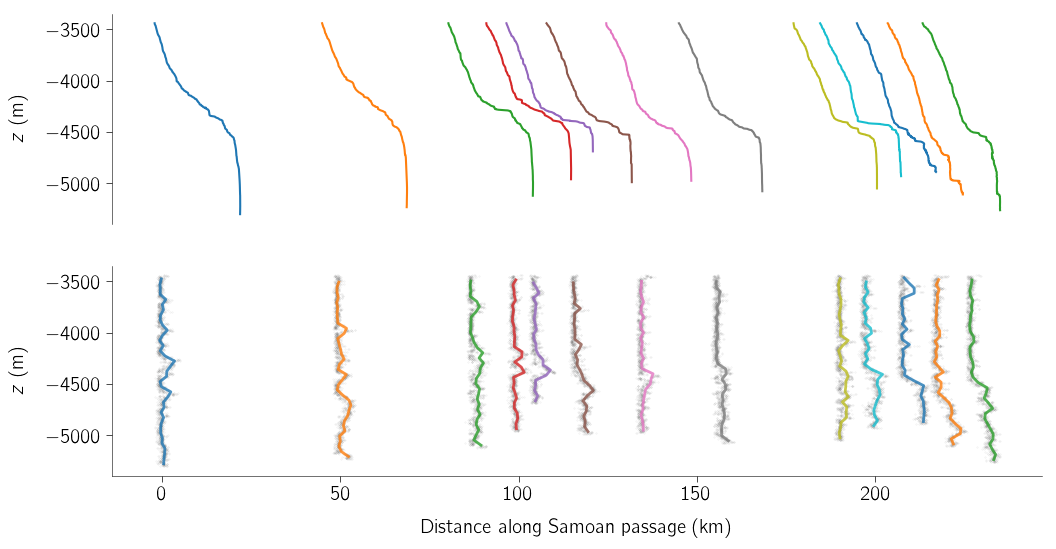

In [4]:
fig, axs = subplots(nrows=2, figsize=(12, 6))

sca(axs[1])
sidespine()
axs[1][:tick_params](bottom=false, labelbottom=false)
ylabel(L"z \, \, \mathrm{(m)}", labelpad=12.0)

sca(axs[2])
cornerspines()
xlabel("Distance along Samoan passage (km)"; labelpad=12.0)
ylabel(L"z \, \, \mathrm{(m)}", labelpad=12.0)

m_ep = 2e3 # [ep]/[distance]
m_sig = 2e8

for (i, profile) in enumerate(values(vmp))
    z, ep, sig = unpack_vmp_profile(profile)
    z_coarse = range(minimum(z), stop=maximum(z), step=50)
    z_ep, ep_coarse = enmesh(z_coarse, z, ep)
    
    ep_filtered = filter(x->x>0 && isfinite(x), ep)
    offset_ep = nanmean(log.(10, ep_filtered))
    offset_sig = nanminimum(sig)
    gtz = ep .> 0
     
    # Visualize density profile and dissipation along the track.
    sca(axs[1])
    plot(1e-3*(m_sig.*(sig.-offset_sig)) .+ profile["distance"], z, "-")
    
    sca(axs[2])
    plot(1e-3*(m_ep.*(log.(10, ep[gtz]).-offset_ep) .+ profile["distance"]), z[gtz], "k.", linewidth=1, markersize=0.5, alpha=0.1)
    plot(1e-3*(m_ep.*(log.(10, ep_coarse).-offset_ep) .+ profile["distance"]), z_ep, "-", linewidth=2, markersize=2.0, alpha=0.8)   
end

## Grid data in density space

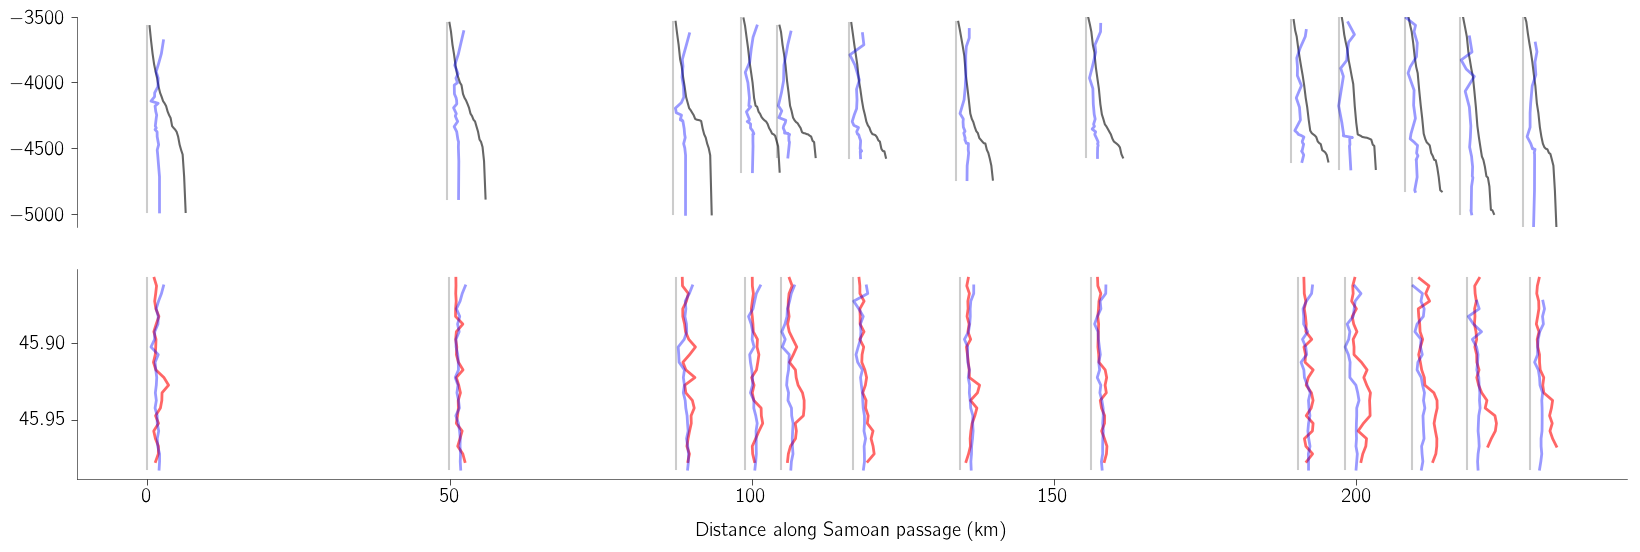

In [5]:
sig0 = 45.855
sigF = 45.985
dsig = 5e-3
sig_edges = range(sig0, stop=sigF, step=dsig)

rho0 = ρ0

m_ep = 1e3 # [ep]/[distance]
m_sig = 5e4
m_dζ = 1e3 # [dζ]/[distance]

fig, axs = subplots(nrows=2, figsize=(20, 6))

sca(axs[1])
sidespine()
axs[1][:tick_params](bottom=false, labelbottom=false)

sca(axs[2])
invertaxis()
cornerspines()
xlabel("Distance along Samoan passage (km)"; labelpad=12.0)

for (i, profile) in enumerate(values(vmp))
    z, ep_raw, sig_raw = unpack_vmp_profile(profile)
    
    sig, ep, dζ, ζ, ζ_edges = layerwise(sig_raw, ep_raw, z, sig_edges)
    
    mean_ep = nanmean(log.(10, ep[ep.>0]))
    min_sig = nanminimum(sig)
    min_dζ = log.(10, nanminimum(dζ[dζ.>0]))
    
    #@show i mean_ep min_sig min_dζ
        
    # Visualize density profile and dissipation along the track.
    sca(axs[1])
    ylim(-5100, -3500)
    plot(1e-3*(m_sig.*(sig .- ρ0 .+ 1e3) .+ profile["distance"]), ζ, "k-", alpha=0.6)
    plot(1e-3*(m_dζ.*log.(10, dζ) .+ profile["distance"]), ζ, "b-", linewidth=2, alpha=0.4)
    
    finiteζ = ζ[abs.(ζ).<Inf]
    plot(1e-3*profile["distance"]*[1, 1], [finiteζ[1], finiteζ[end]], "k-", alpha=0.2)
    
    #axvline(x=1e-3*profile["distance"], color="k", linewidth=1, alpha=0.2)

    sca(axs[2])
    plot(1e-3*(m_ep.*(log.(10, ep) .+ 12) .+ profile["distance"]), sig, "r-", linewidth=2, markersize=0.5, alpha=0.6)
    plot(1e-3*(m_dζ.*log.(10, dζ) .+ profile["distance"]), sig, "b-", linewidth=2, markersize=0.5, alpha=0.4)     
    plot(1e-3*profile["distance"]*[1, 1], [sig[1], sig[end]], "k-", alpha=0.2)
end

In [6]:
sig0 = 45.8525
sigF = 45.9625
dsig = 5e-3
sig_edges = range(sig0, stop=sigF, step=dsig)

# a[nsigma, nvmp]. 
sig, ep, dζ, ζ, ζ_edges = layer_vmp_data(vmp, sig_edges)

# Local diffusivity
ii = dζ .> 0
kappa_local = 0ep
kappa_local[ii] = localdiffusivity.(ep[ii], -dsig, dζ[ii]) # @. 0.2 * ep[ii] / N2[ii] 

# Averages
kappa_avg = passage_average(kappa_local, vmp)
dζ_avg = passage_average(dζ, vmp)
ep_avg = passage_average(ep, vmp)

kappa_eff = effectivediffusivity.(ep_avg, -dsig, dζ_avg)

@show length(sig_edges)-1 nanmaximum(ζ_edges) nanminimum(ζ_edges) median(dζ)

dζ_avg

length(sig_edges) - 1 = 22
nanmaximum(ζ_edges) = -3443.9644506533396
nanminimum(ζ_edges) = -5105.615495432081
median(dζ) = 46.65112950573621


22-element Array{Float64,1}:
 66.8298290570601  
 71.64994275150902 
 78.69415066786853 
 79.79741623793674 
 72.67738898561348 
 87.53544901225732 
 67.15004274759092 
 68.06474419900108 
 67.37760846644899 
 64.54083573633196 
 48.380141139955995
 40.931867973738285
 26.678249075275804
 24.71880987910602 
 22.687574842799407
 19.820765816704284
 23.180283115122396
 13.02931718649835 
 25.66910429966016 
 36.04587083809391 
 35.99573853662935 
 33.72305671750394 

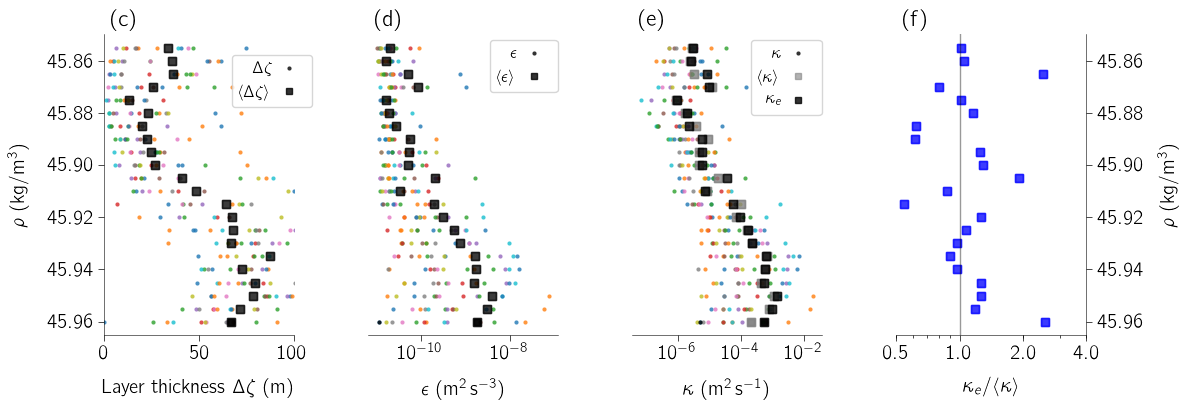

In [7]:
fs = 16
xtextpos = 0.03
ytextpos = 1.01
legsize = 12

fig, axs = subplots(ncols=4, figsize=(12, 4), sharey=true)

sca(axs[1])
xlabel("Layer thickness \$ \\Delta \\zeta \$ (m)", labelpad=12.0)
ylabel(L"\rho \, \, \mathrm{(kg/m^3)}", labelpad=12.0)
invertaxis()
cornerspines()
xlim(0, 100)
yticks(sig[1:4:end, 1])

plot(dζ, sig, ".", alpha=0.8, markeredgewidth=0.0, markersize=6)
plot(dζ_avg, sig, "ks", alpha=0.1)

plot(dζ[1], sig[1], "k.", alpha=0.8, markersize=6, markeredgewidth=0.0, label=L"\Delta \zeta")
plot(dζ_avg[1], sig[1], "ks", alpha=0.8, markersize=4, label=L"\langle \Delta \zeta \rangle")
#legend()
legend(loc="upper right", bbox_to_anchor=(1.1, 0.93), 
       prop=Dict("size"=>legsize), markerfirst=false, markerscale=1.0, borderaxespad=0.0, frameon=true, handletextpad=0.05)

sca(axs[2])
xlabel(L"\epsilon \,\, \mathrm{(m^2 \, s^{-3})}", labelpad=12.0)
invertaxis()
bottomspine()
xscale("log")
#xlim(1e-11, 1e-7)
axs[2][:tick_params](left=false, labelleft=false)

plot(ep, sig, ".", alpha=0.8, markeredgewidth=0.0, markersize=6)
plot(ep_avg, sig, "ks", alpha=0.1)

plot(ep[1], sig[1], "k.", alpha=0.8, markersize=6, markeredgewidth=0.0, label=L"\epsilon")
plot(ep_avg[1], sig[1], "ks", alpha=0.8, markersize=4, label=L"\langle \epsilon \rangle")
#legend()
legend(loc="upper right", bbox_to_anchor=(1.0, 0.98), 
       prop=Dict("size"=>legsize), markerfirst=false, markerscale=1.0, borderaxespad=0.0, frameon=true, handletextpad=0.05)

sca(axs[3])
xlabel(L"\kappa \,\, \mathrm{(m^2 \, s^{-1})}", labelpad=12.0)
invertaxis()
bottomspine()
xscale("log")
axs[3][:tick_params](left=false, labelleft=false)

plot(kappa_local, sig, ".", alpha=0.8, markeredgewidth=0.0, markersize=6)
plot(kappa_avg, sig, linestyle="", marker="s", color="gray", alpha=0.1)
plot(kappa_eff, sig, "ks", alpha=0.1)

plot(kappa_local[1], sig[1], "k.", alpha=0.8, markeredgewidth=0.0, markersize=6, label=L"\kappa")
plot(kappa_avg[1], sig[1], linestyle="", marker="s", color="gray", alpha=0.6, markersize=4, label=L"\langle \kappa \rangle")
plot(kappa_eff[1], sig[1], "ks", alpha=0.8, markersize=4, label=L"\kappa_e")
#legend()
legend(loc="upper right", bbox_to_anchor=(1.0, 0.98), 
       prop=Dict("size"=>legsize), markerfirst=false, markerscale=1.0, borderaxespad=0.0, frameon=true, handletextpad=0.05)

sca(axs[4])
xlabel(L"\kappa_e / \langle \kappa \rangle", labelpad=12.0)
ylabel(L"\rho \, \, \mathrm{(kg/m^3)}", labelpad=12.0)
invertaxis()
cornerspines(side="right")
xscale("log")
axs[4][:tick_params](left=false, labelleft=false)

plot(kappa_eff./kappa_avg, sig, "bs", alpha=0.1)
axvline(x=1, color="k", alpha=0.4, linewidth=1)
xticks([0.5, 1, 2, 4])
scalartickformat("x", axs[4])

invertaxis(axs[1])

text(xtextpos, ytextpos, "(c)", transform=axs[1][:transAxes], ha="left", va="bottom", fontsize=fs)
text(xtextpos, ytextpos, "(d)", transform=axs[2][:transAxes], ha="left", va="bottom", fontsize=fs)
text(xtextpos, ytextpos, "(e)", transform=axs[3][:transAxes], ha="left", va="bottom", fontsize=fs)
text(xtextpos, ytextpos, "(f)", transform=axs[4][:transAxes], ha="left", va="bottom", fontsize=fs)

tight_layout(w_pad=4.0)
plotname = "samoanresults.png"
savefig(plotname, dpi=960)